**DATASET**

The both training and evaluation operations would be handled with [Fec2013](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) dataset. Compressed version of the dataset takes 92 MB space whereas uncompressed version takes 295 MB space. There are 28K training and 3K testing images in the dataset. Each image was stored as 48×48 pixel. The pure dataset consists of image pixels (48×48=2304 values), emotion of each image and usage type (as train or test instance).

In [0]:
#Unzipping the file
!tar -xf /content/drive/My\ Drive/fer2013.tar.gz

In [8]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

#------------------------------
#cpu - gpu configuration
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
#------------------------------
#variables
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 25
#------------------------------
#read kaggle facial expression recognition challenge dataset (fer2013.csv)
#https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

with open("fer2013/fer2013.csv") as f:
  content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

#------------------------------
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
      print("", end="")

#------------------------------
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#------------------------------
#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
#------------------------------
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

#------------------------------

model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)

#------------------------------

fit = True

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs) #train for randomly selected one
else:
	model.load_weights('/data/facial_expression_model_weights.h5') #load weights
	
#------------------------------
"""
#overall evaluation
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])
"""
#------------------------------
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
#------------------------------



Using TensorFlow backend.


number of instances:  35888
instance length:  2304
28709 train samples
3589 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
256/256 [==============================] - 577s 2s/step - loss: 1.7888 - acc: 0.2605
Epoch 2/25
256/256 [==============================] - 549s 2s/step - loss: 1.5654 - acc: 0.3806
Epoch 3/25
256/256 [==============================] - 542s 2s/step - loss: 1.3963 - acc: 0.4630
Epoch 4/25
256/256 [==============================] - 539s 2s/step - loss: 1.2822 - acc: 0.5088
Epoch 5/25
256/256 [==============================] - 580s 2s/step - loss: 1.2005 - acc: 0.5428
Epoch 6/25
256/256 [==============================] - 582s 2s/step - loss: 1.1290 - acc: 0.5708
Epoch 7/25
256/256 [==============================] - 592s 2s/step - loss: 1.0604 - acc: 0.5977
Epoc

In [0]:
#Saving the model
model.save('model25.h5')

In [7]:
#Evaluation
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.09486687888900204
Train accuracy: 97.07060503674806
Test loss: 2.65737425945502
Test accuracy: 57.50905544803015


In [9]:
#Confusion Matrix.

from sklearn.metrics import classification_report, confusion_matrix
 
pred_list = []; actual_list = []
 
for i in predictions:
 
  pred_list.append(np.argmax(i))
 
for i in y_test:
 
  actual_list.append(np.argmax(i))
 
confusion_matrix(actual_list, pred_list)

array([[227,   4,  47,  24,  79,  16,  70],
       [ 19,  29,   0,   2,   6,   0,   0],
       [ 59,   4, 187,  18, 102,  50,  76],
       [ 49,   3,  28, 659,  55,  27,  74],
       [ 77,   2,  71,  40, 310,  22, 131],
       [ 12,   0,  38,  15,  13, 320,  17],
       [ 53,   1,  44,  48, 113,  16, 332]])

In [0]:
monitor_testset_results = True

if monitor_testset_results == True:
	#make predictions for test set
	predictions = model.predict(x_test)

	index = 0
	for i in predictions:
		if index < 30 and index >= 20:
			#print(i) #predicted scores
			#print(y_test[index]) #actual scores
			
			testing_img = np.array(x_test[index], 'float32')
			testing_img = testing_img.reshape([48, 48]);
			
			plt.gray()
			plt.imshow(testing_img)
			plt.show()
			
			print(i)
			
			emotion_analysis(i)
			print("----------------------------------------------")
		index = index + 1

In [1]:
from keras.models import load_model
model = load_model('model25.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


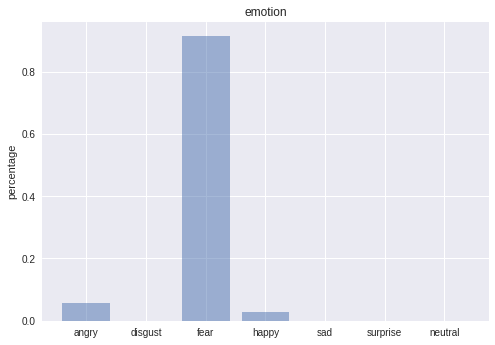

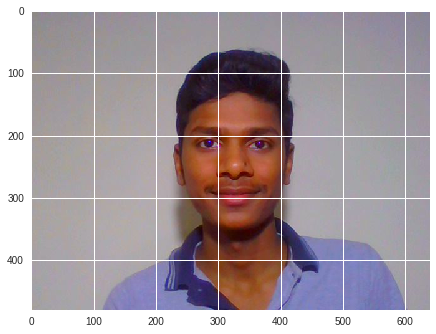

In [19]:
#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = 'photo.jpg'
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

In [0]:
import cv2
            
def facecrop(image):  
    facedata = "haarcascade_frontalface_default.xml"
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite('capture.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)

    #cv2.imshow(image, img)


if __name__ == '__main__':
    facecrop('1.jpg')


In [0]:
#CODE for Capturing an image on Colab from here: https://colab.research.google.com/notebook#fileId=1OnUy6eFE7XhdfGfAHDCqQxpwueTOj_NO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [18]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'